In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import os

import numpy as np
import pandas as pd
import seaborn as sns

from dpipe.config import get_resource_manager

from tqdm import tqdm

In [3]:
rm = get_resource_manager('/home/krivov/deep_pipe/config_examples/brats.config')

dataset = rm.dataset
patient_ids = dataset.patient_ids

In [4]:
stats = {}

for patient_id in tqdm(patient_ids):
    mscan = dataset.load_mscan(patient_id)
    segm = dataset.load_segm(patient_id)
    msegm = dataset.load_msegm(patient_id)
    
    stats[patient_id] = {
        'brain_vol': np.sum(mscan > mscan.min()),
        
        'cancer1_vol': np.sum(segm == 1),
        'cancer2_vol': np.sum(segm == 2),
        'cancer3_vol': np.sum(segm == 3),
        
        'WT_vol': np.sum(msegm[0].sum()),
        'TC_vol': np.sum(msegm[1].sum()),
        'ET_vol': np.sum(msegm[2].sum()),
        
        'brain_shape_x': mscan.shape[1],
        'brain_shape_y': mscan.shape[2],
        'brain_shape_z': mscan.shape[3]
    }

100%|██████████| 285/285 [12:46<00:00,  2.69s/it]


In [41]:
df = pd.DataFrame(stats).T

In [42]:
segm_vol_cols = ['brain_vol', *[f'cancer{i}_vol' for i in range(1, 4)]]
msegm_vol_cols = ['brain_vol', *[f'{type}_vol' for type in ('WT', 'TC', 'ET')]]
shape_cols = [f'brain_shape_{c}' for c in 'xyz']

In [91]:
def pairplot(data):
    g = sns.PairGrid(data, size=4, diag_sharey=False)
    g.map_upper(sns.regplot)
    g.map_lower(sns.kdeplot, cmap=cm.Dark2)
    g.map_diag(sns.distplot, bins=20);

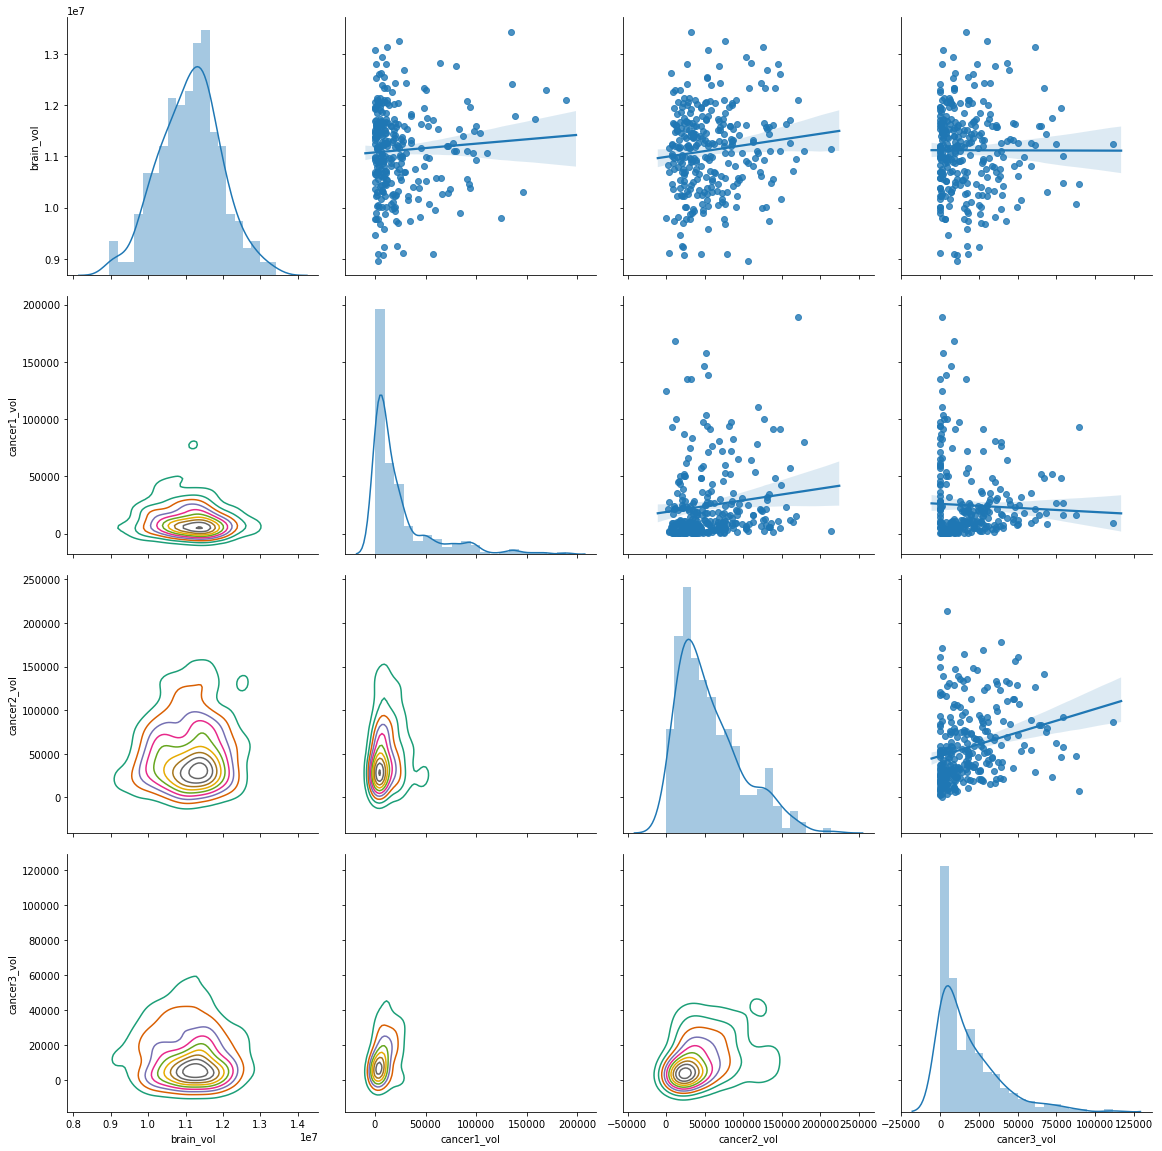

In [92]:
pairplot(df[segm_vol_cols])

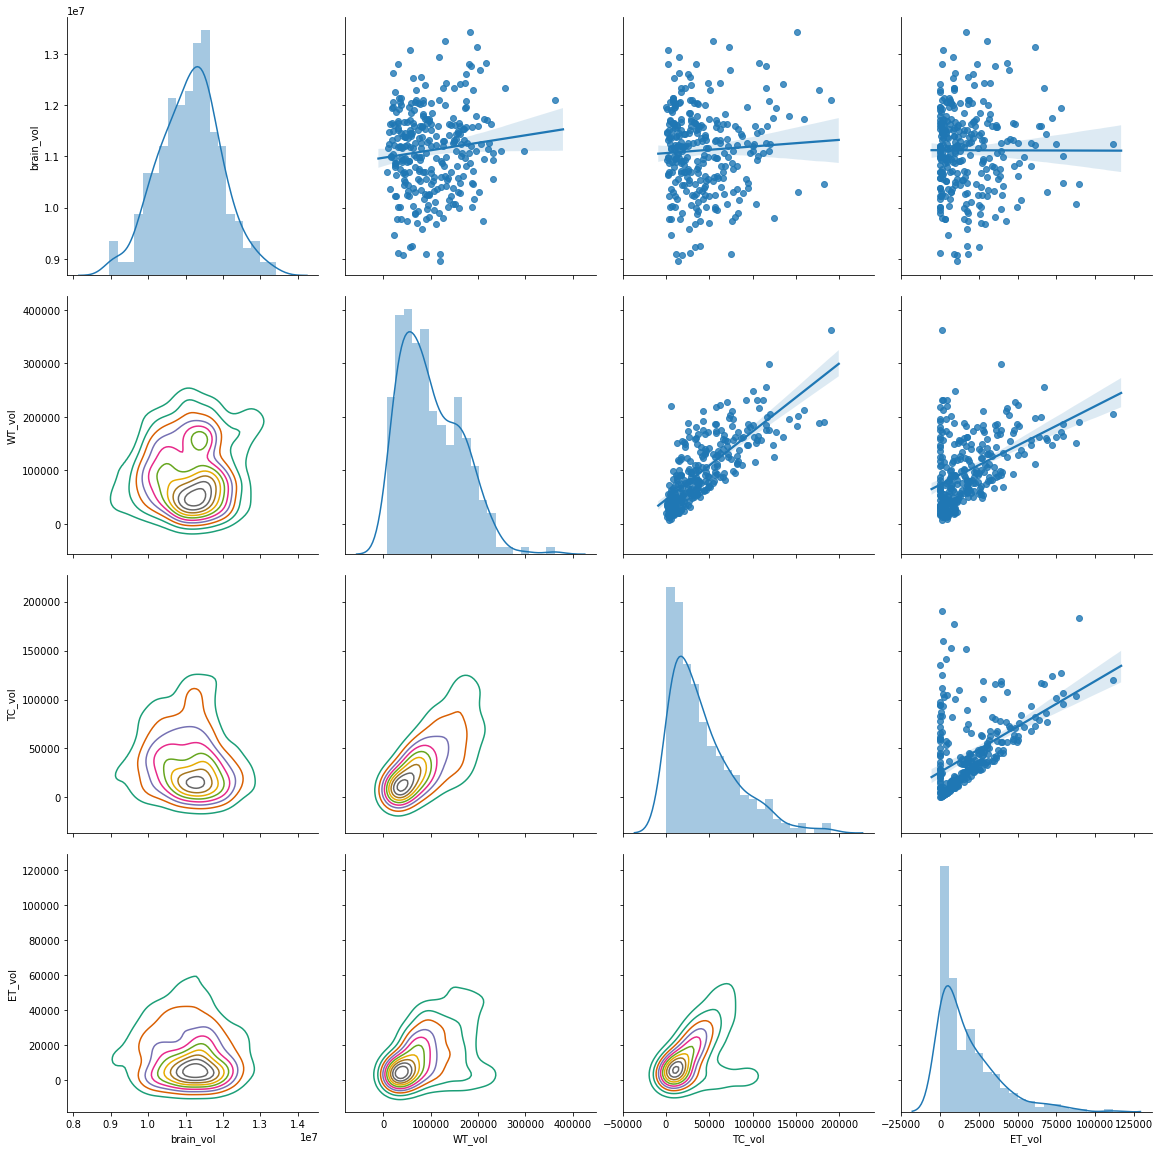

In [93]:
pairplot(df[msegm_vol_cols])

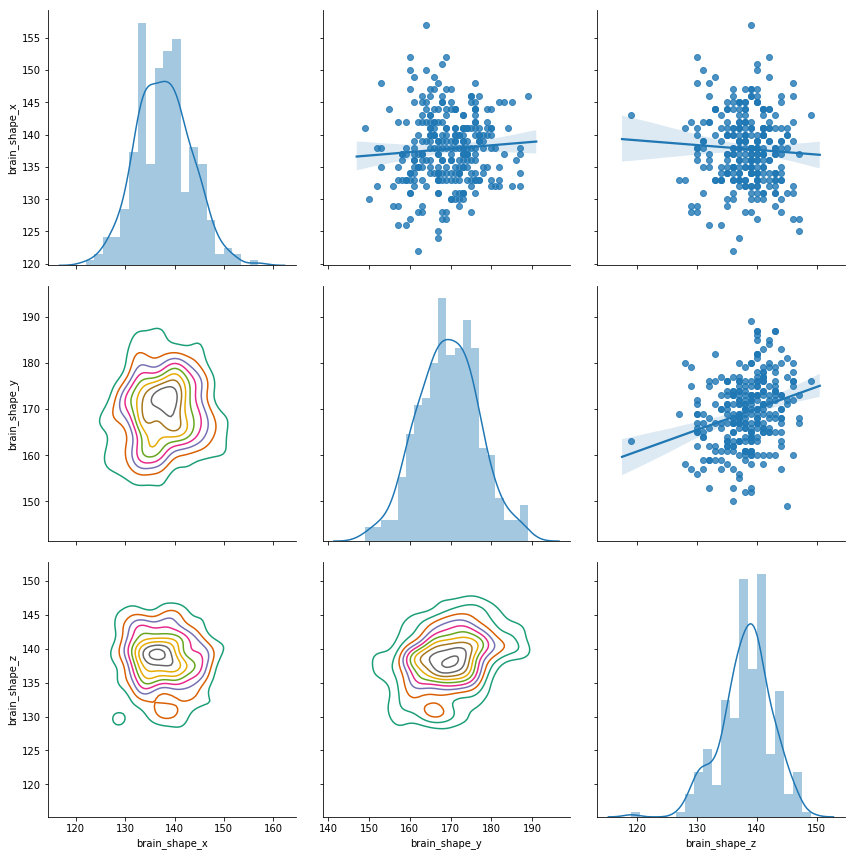

In [94]:
pairplot(df[shape_cols])

138.0
169.0
139.0


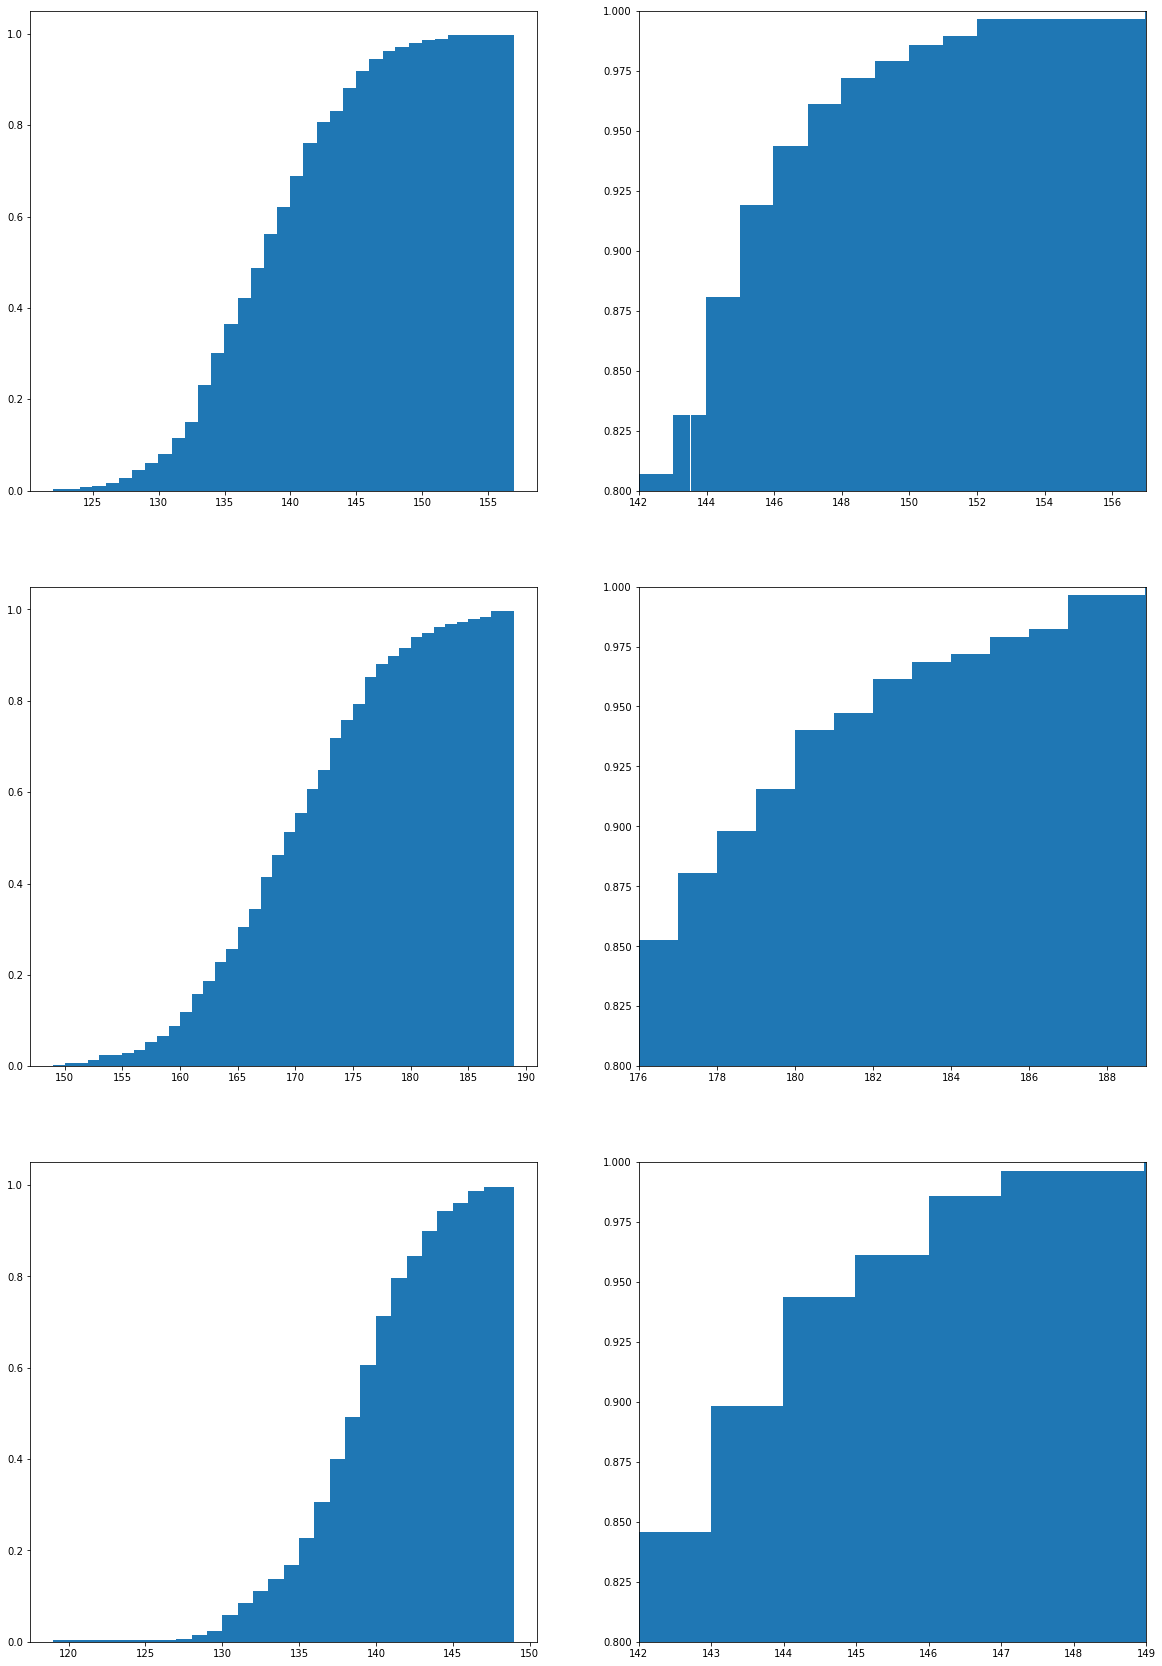

In [106]:
fig, ax = plt.subplots(3, 2, figsize=(20, 30))

for i, dim in enumerate('xyz'):
    data = df[f'brain_shape_{dim}']
    ax[i, 0].hist(data, bins=1000, cumulative=True, normed=True);
    ax[i, 1].hist(data, bins=1000, cumulative=True, normed=True);
    ax[i, 1].set_xlim((np.percentile(data, 80), np.max(data)))
    ax[i, 1].set_ylim((0.8, 1))
    
    print(np.percentile(data, 50))
    
plt.show()

In [8]:
def compute_size_out(size_in, stride, depth):
    size_out = size_in
    for _ in range(depth - 1):
        size_out = stride * (size_out - 1) + 1
    return size_out

max_size = 190
min_size = 130

def find_configurations(min_size, max_size):
    configurations = []
    for depth in range(3, 4):
        for stride in range(3, 4):
            for size_in in in range(7, 100):
                size_out = compute_size_out(size_in, stride, depth)
                if size_out > max_size:
                    break
                elif size_out > min_size:
                    configurations.append((size_out, size_in, stride, depth))
    return pd.DataFrame(configurations, columns=['size_out', 'size_in', 'stride', 'depth'])

In [9]:
configurations = find_configurations(min_size, max_size)
configurations

,size_out,size_in,stride,depth
0,133,45,3,2
1,136,46,3,2
2,139,47,3,2
3,142,48,3,2
4,145,49,3,2
5,148,50,3,2
6,151,51,3,2
7,154,52,3,2
8,157,53,3,2
9,160,54,3,2


### Intensity distribution for different cancer tissues

In [6]:
def show_hist_stats(scan, segmentation, show=True, bins=60, ax=None):
    #fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    for cancer_type in [0,1,2,4]:
        mask = (segmentation == cancer_type)
        
        vals = scan[mask]
        if len(vals) == 0:
            continue
            
        drop_val = vals.min()
        vals = vals[vals != drop_val]
    
        top = np.percentile(vals, 99)
        vals = vals[vals < top]
        vals = np.clip(vals, drop_val, top)
    
        sns.distplot(vals, bins=bins, ax=ax)
    if show:
        plt.show()

100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


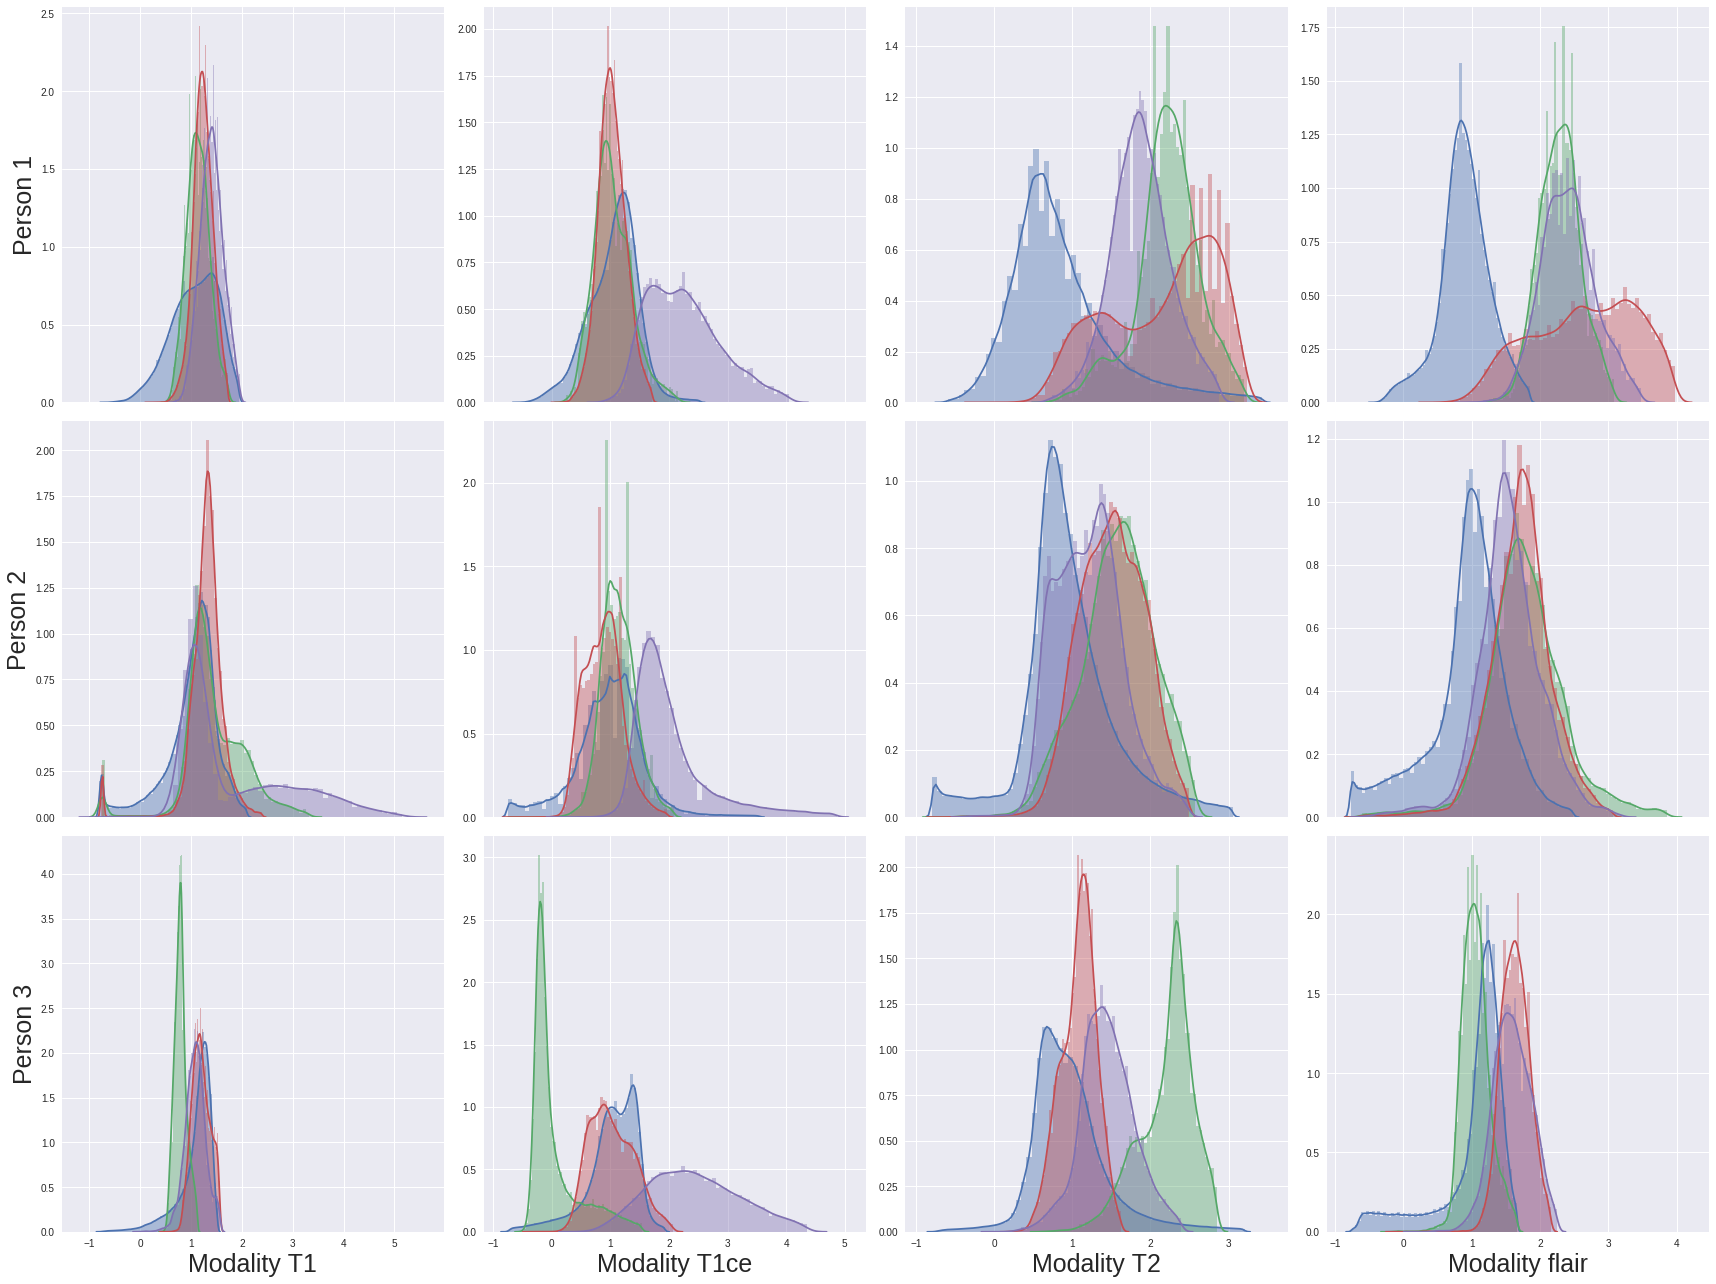

In [13]:
n_mscans = 3
n_modals = 4
fig, ax = plt.subplots(n_mscans, n_modals, figsize=(6*n_modals, 6*n_mscans),
                       sharex='col')

for i in tqdm(range(n_mscans)):
    ax[i, 0].set_ylabel('Person {}'.format(i+1), fontsize=25)
    for j, m_name in enumerate(['T1', 'T1ce', 'T2', 'flair']):
        show_hist_stats(medim.prep.normalize_scan(mscans[i][j]), segmentations[i], show=False, ax=ax[i, j])
        #ax[i, j].set_fontsize(12)
        
for j, m_name in enumerate(['T1', 'T1ce', 'T2', 'flair']):
    ax[i, j].set_xlabel('Modality {}'.format(m_name), fontsize=25)
    
        
plt.tight_layout()
plt.show()